In [79]:
import re
import numpy as np
import matplotlib as mpl
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="white", context="talk")
from collections import Counter
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import json as json
from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix

In [80]:
train_df = pd.read_json( "train.json" , encoding='utf-8')
test_df = pd.read_json("test.json",encoding='utf-8')
train_df.shape, test_df.shape

((29774, 3), (10000, 2))

In [81]:
train_df.head()

,cuisine,id,ingredients
0,italian,0,"[penne, shallots, rice vinegar, fresh basil, g..."
1,greek,1,"[sugar, chopped walnuts, filo dough, chopped a..."
2,italian,2,"[fresh rosemary, chopped fresh thyme, fresh or..."
3,southern_us,3,"[sugar, hot sauce, ramps, vinegar, cream chees..."
4,french,4,"[ground cinnamon, panettone, whipped cream, Am..."


In [82]:
test_df.head()


,id,ingredients
0,29774,"[eggs, beef stock, rice cakes]"
1,29775,"[pasta, orange, fresh thyme, peas, celery, tom..."
2,29776,"[olive oil, onions, red wine, top sirloin stea..."
3,29777,"[ground black pepper, patis, chicken stock, ga..."
4,29778,"[black pepper, garlic cloves, tomato paste, sa..."


In [83]:
cut_useless_ingredients = Counter({k: v for k, v in ingredients_amount.items() if v >= 5})
len(cut_useless_ingredients)


2945

In [84]:
ingredients_amount = Counter()
for ingredients in train_df['ingredients']:
    ingredients_amount.update(ingredients)
len(ingredients_amount)

6199

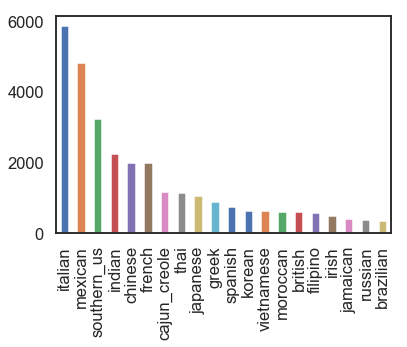

In [85]:
train_df['cuisine'].value_counts().plot(kind='bar')

In [86]:
counters = {}
for cuisine in train_df['cuisine'].unique():
    counters[cuisine] = Counter()
    indices = (train_df['cuisine'] == cuisine)
    for ingredients in train_df[indices]['ingredients']:
        counters[cuisine].update(ingredients)

In [87]:
print("italian: ", counters['italian'].most_common(10) )


italian:  [('salt', 2575), ('olive oil', 2306), ('garlic cloves', 1204), ('grated parmesan cheese', 1176), ('garlic', 1100), ('ground black pepper', 1052), ('extra-virgin olive oil', 1044), ('onions', 921), ('water', 798), ('butter', 772)]


In [88]:
counters['mexican'].most_common(10)

[('salt', 2072),
 ('onions', 1118),
 ('garlic', 1014),
 ('ground cumin', 990),
 ('olive oil', 973),
 ('chili powder', 927),
 ('jalapeno chilies', 878),
 ('sour cream', 811),
 ('avocado', 777),
 ('corn tortillas', 696)]

In [89]:
mostused = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(10)] for cuisine in counters],
            index=[cuisine for cuisine in counters],
            columns=[i for i in range(1, 11)])
mostused

,1,2,3,4,5,6,7,8,9,10
italian,salt,olive oil,garlic cloves,grated parmesan cheese,garlic,ground black pepper,extra-virgin olive oil,onions,water,butter
greek,salt,olive oil,dried oregano,feta cheese crumbles,garlic cloves,fresh lemon juice,garlic,ground black pepper,extra-virgin olive oil,pepper
southern_us,salt,butter,all-purpose flour,sugar,large eggs,baking powder,water,unsalted butter,milk,buttermilk
french,salt,sugar,all-purpose flour,unsalted butter,butter,olive oil,large eggs,water,garlic cloves,ground black pepper
mexican,salt,onions,garlic,ground cumin,olive oil,chili powder,jalapeno chilies,sour cream,avocado,corn tortillas
moroccan,olive oil,salt,ground cumin,onions,ground cinnamon,garlic cloves,ground ginger,water,carrots,paprika
russian,salt,sugar,onions,all-purpose flour,sour cream,eggs,water,butter,unsalted butter,large eggs
indian,salt,onions,garam masala,water,ground turmeric,garlic,ground cumin,cumin seed,vegetable oil,oil
japanese,soy sauce,salt,sugar,mirin,water,sake,rice vinegar,vegetable oil,scallions,sesame oil
vietnamese,fish sauce,sugar,salt,garlic,water,carrots,soy sauce,garlic cloves,vegetable oil,shallots


In [90]:
train_df['ingredients'] = train_df['ingredients'].apply(','.join)
test_df['ingredients'] = test_df['ingredients'].apply(','.join)
X_train = train_df['ingredients']
X_test = test_df['ingredients']

In [91]:
print(X_train)

0        penne,shallots,rice vinegar,fresh basil,ground...
1        sugar,chopped walnuts,filo dough,chopped almon...
2        fresh rosemary,chopped fresh thyme,fresh orega...
3        sugar,hot sauce,ramps,vinegar,cream cheese,gro...
4        ground cinnamon,panettone,whipped cream,Amaren...
5        kosher salt,jalapeno chilies,purple onion,cano...
6                   water,freshly ground pepper,salt,grits
7        green chile,salt,onions,onion powder,chicken i...
8        garlic powder,pork spareribs,sesame seeds,crus...
9        garbanzo beans,fat skimmed chicken broth,groun...
10       granulated sugar,all-purpose flour,eggs,vanill...
11       jack cheese,green chilies,cream of chicken sou...
12       chickpea flour,cilantro leaves,asafetida,chili...
13       fresh basil,peach nectar,water,sugar,vanilla b...
14       sweet potatoes,beer,cake flour,red bell pepper...
15       cilantro sprigs,coriander seeds,fresh lemon ju...
16       tomato sauce,prepar salsa,oregano,shredded che.

In [92]:
train_df.head()

,cuisine,id,ingredients
0,italian,0,"penne,shallots,rice vinegar,fresh basil,ground..."
1,greek,1,"sugar,chopped walnuts,filo dough,chopped almon..."
2,italian,2,"fresh rosemary,chopped fresh thyme,fresh orega..."
3,southern_us,3,"sugar,hot sauce,ramps,vinegar,cream cheese,gro..."
4,french,4,"ground cinnamon,panettone,whipped cream,Amaren..."


In [93]:
unique = np.unique(mostused.values.ravel())
unique

array(['all-purpose flour', 'avocado', 'baking powder', 'baking soda',
       'black pepper', 'butter', 'buttermilk', 'cachaca',
       'cajun seasoning', 'carrots', 'cayenne pepper', 'chili powder',
       'coconut milk', 'corn starch', 'corn tortillas', 'cumin seed',
       'dried oregano', 'dried thyme', 'eggs', 'extra-virgin olive oil',
       'feta cheese crumbles', 'fish sauce', 'fresh lemon juice',
       'garam masala', 'garlic', 'garlic cloves',
       'grated parmesan cheese', 'green bell pepper', 'green onions',
       'ground allspice', 'ground black pepper', 'ground cinnamon',
       'ground cumin', 'ground ginger', 'ground turmeric',
       'jalapeno chilies', 'large eggs', 'lime', 'milk', 'mirin', 'oil',
       'olive oil', 'onions', 'paprika', 'pepper', 'potatoes',
       'red bell pepper', 'rice vinegar', 'sake', 'salt', 'scallions',
       'sesame oil', 'sesame seeds', 'shallots', 'sour cream',
       'soy sauce', 'sugar', 'tomatoes', 'unsalted butter',
       'vegeta

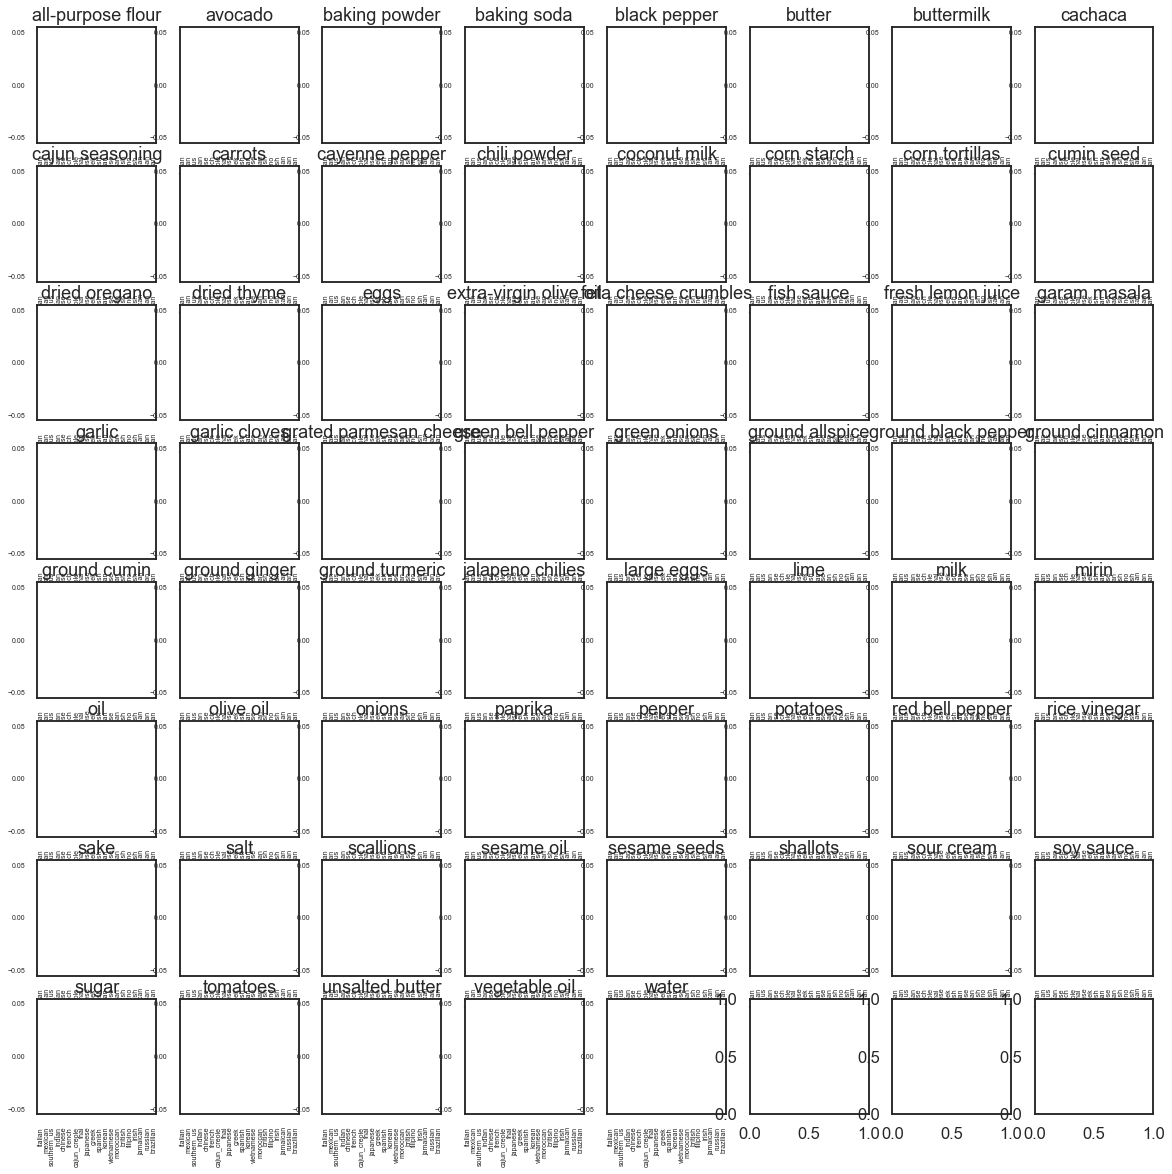

In [94]:
train_df['all_ingredients'] = train_df['ingredients'].map(";".join)

fig, axes = plt.subplots(8, 8, figsize=(20, 20))
for ingredient, ax_index in zip(unique, range(64)):
    indices = train_df['all_ingredients'].str.contains(ingredient)
    relative_freq = (train_df[indices]['cuisine'].value_counts() / train_df['cuisine'].value_counts())
    relative_freq.plot(kind='bar', ax=axes.ravel()[ax_index], fontsize=7, title=ingredient)

In [95]:
encoder = preprocessing.LabelEncoder() 
y_train_transformed = encoder.fit_transform(train_df['cuisine']) # label y 

In [96]:


encoder = preprocessing.LabelEncoder() 
y_train_transformed = encoder.fit_transform(train_df['cuisine']) # label y 



vec = TfidfVectorizer(binary = True).fit(X_train.values)
X_train_transformed = vec.transform(X_train.values) 
X_test_transformed = vec.transform(X_test.values)  


In [97]:
X_for_train, X_for_test, y_for_train, y_for_test = train_test_split(X_train_transformed, y_train_transformed ,test_size= 0.25, random_state = 0)
clf = svm.LinearSVC(C=0.5, max_iter=100, random_state=20, tol=0.5)
clf.fit(X_for_train, y_for_train)
y_pred = clf.predict(X_for_test)  

In [98]:
print(accuracy_score(y_for_test, y_pred))

0.7868081676518001


In [99]:
y_pred = clf.predict(X_test_transformed)
y_pred_transformed = encoder.inverse_transform(y_pred) #transfor y back from numbers

predictions = pd.DataFrame({'id': test_df['id'], 'cuisine': y_pred_transformed})



In [101]:

predictions.shape

(10000, 2)

In [102]:
predictions.to_csv('kaggle_submit.csv', index = False)

